In [1]:
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


In [2]:
class Preprocessing:
    # def __init__(self, data):
    #     self.data = data

    @classmethod
    def mean_imputation(self, data, inplace = False):
        data.fillna(data.mean(), inplace = inplace)

    @classmethod
    def median_imputation(self, data, inplace = False):
        data.fillna(data.median(), inplace = inplace)

    @classmethod
    def mode_imputation(self, data, inplace = False):
        data.fillna(data.mode(), inplace = inplace)

    @classmethod
    def tree_imputation(self, data):
        missing_cols = [col for col in data.columns if data[col].isnull().sum() > 0]
        non_missing_cols = [col for col in data.columns if data[col].isnull().sum() == 0]
    
        for col in missing_cols:
            model = BaggingRegressor(DecisionTreeRegressor(), n_estimators = 40, max_samples = 1.0,
                                     max_features = 1.0, bootstrap = False, n_jobs = -1)

            col_missing = data[data[col].isnull()]
            temp = data.drop(data[data[col].isnull()].index, axis = 0)
            
            X = temp.loc[:, non_missing_cols]
            y = temp[col]
    
            model.fit(X, y)
    
            y_pred = model.predict(col_missing[non_missing_cols])
    
            data.loc[col_missing.index, col] = y_pred
        
        return data

    @classmethod
    def find_outliers(self, data, feature):
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    

    @classmethod
    def encoding(self, df):
        education_mapping = {'Unknown': 0, 'Uneducated': 1, 'High School': 2, 'College': 3,
                             'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6}
        income_mapping = {'Unknown': 0, 'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3,
                          '$80K - $120K': 4, '$120K +': 5}
        card_mapping = {'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}
        gender_mapping = {'F': 0, 'M': 1}
        marital_mapping = {'Divorced': 0, 'Unknown': 1, 'Single': 2, 'Married': 3}
        
        
        # Apply mapping to each categorical feature
        df['Education_Level'] = df['Education_Level'].map(education_mapping)
        df['Income_Category'] = df['Income_Category'].map(income_mapping)
        df['Card_Category'] = df['Card_Category'].map(card_mapping)
        df['Gender'] = df['Gender'].map(gender_mapping)
        df['Marital_Status'] = df['Marital_Status'].map(marital_mapping)
        
        
        # # One-hot Encoding for nominal Categorical Features
        # columns_to_encode = ['Gender', 'Marital_Status']
        # encoder = OneHotEncoder(drop='first', dtype=np.float64, handle_unknown='ignore', sparse_output=False)
        # encoded = encoder.fit_transform(df[columns_to_encode])
        # encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(columns_to_encode))
        # df = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)

        # # put nan for missied values
        # for column in columns_to_encode:
        #     nan_col = column + '_nan'
        #     encoded_columns = [col for col in df.columns if col.startswith(column + '_') and col != nan_col]
        #     for encoded_col in encoded_columns:
        #         df.loc[df[nan_col] == 1, encoded_col] = np.nan
        
        # # Drop the NaN indicator columns
        # df = df.drop(columns=[col + '_nan' for col in columns_to_encode])
        
        return df


    @classmethod
    def split(self, data, size=0.2, seed=42):
        train_df, test_df = train_test_split(df, test_size=size, shuffle=True, random_state=seed)
        return train_df, test_df


    @classmethod
    def wisker(self, column):
        q1, q3 = np.percentile(column, [25, 75])
        iqr = q3 - q1
        lw = q1 - 1.5 * iqr
        uw = q3 + 1.5 * iqr
        return lw, uw

    @classmethod
    def treat_outlier(self, data, data_columns):
        def cap(x):
            q5 = np.percentile(x, 5)
            q25 = np.percentile(x, 25)
            q75 = np.percentile(x, 75)
            up_trend = np.percentile(x, 95)
            IQR = q75 - q25
            LTV = q25 - 1.5 * IQR
            UTV = q75 + 1.5 * IQR
            
            # Cap the values
            capped = np.where(x > UTV, up_trend, np.where(x < LTV, q5, x))
            return capped
        
        for col in data_columns:
            data[col] = cap(data[col])
        return data
        

    @classmethod
    def scale(self, x_train, x_test):
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        return x_train, x_test


    

In [3]:
class Model:
    
    @classmethod
    def print_logs(self, model, x_train, x_test, y_train, y_test, y_predict):
        print(f'Train score {model.score(x_train, y_train)}')
        print(f'Test score {model.score(x_test, y_test)}')
        print("MAE:" , mean_absolute_error(y_test, y_predict))
        print("MSE:" , mean_squared_error(y_test, y_predict))
        print("RMSE:" , np.sqrt(mean_squared_error(y_test, y_predict)))
        print("R2:" , r2_score(y_test, y_predict))

    
    @classmethod
    def poly_reg(self, x_train, x_test, y_train, y_test, degree):
    
        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_poly_train = poly_features.fit_transform(x_train)
        x_poly_test = poly_features.transform(x_test)
        
        # Fit linear regression model
        model = LinearRegression()
        model.fit(x_poly_train, y_train)
        
        # Predict
        y_pred = model.predict(x_poly_test)
        return y_pred

    @classmethod
    def random_forest_reg(self, x_train, y_train, x_test, y_test):
        rf = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
        rf.fit(x_train, y_train)
        
        oob_score = rf.oob_score_
        print(f'Out-of-Bag Score: {oob_score}')
        
        y_pred = rf.predict(x_test)
        
        mse = mean_squared_error(y_test, y_pred)
        print(f'Mean Squared Error (MSE): {mse}')
        
        r2 = r2_score(y_test, y_pred)
        print(f'R-squared (R2): {r2}')
        
        return y_pred, mse, r2


    @classmethod
    def cluster_reg(self, x_train, x_test, y_train, y_test):
        
        X = x_train
        y = y_train
        
        kmeans = KMeans(n_clusters=3)  # Set the number of clusters as desired
        clusters = kmeans.fit_predict(X)

        regressors = {}

        # Train Regressors for Each Cluster
        for cluster_label in range(kmeans.n_clusters):
            # Filter data points belonging to the current cluster
            X_cluster = X[clusters == cluster_label]
            y_cluster = y[clusters == cluster_label]
    
            X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
            
            regressor = LinearRegression()
            regressor.fit(X_train_c, y_train_c)
    
            regressors[cluster_label] = regressor
            
            # Evaluate the model
            score = regressor.score(X_test_c, y_test_c)
            print(f"Cluster {cluster_label}: R^2 Score = {score}")

        # Prediction
        new_clusters = kmeans.predict(x_test)

        # Predict using the corresponding regressor for each cluster
        for i, cluster_label in enumerate(new_clusters):
            X_new_cluster = x_test[i:i+1]  
            predicted_value = regressors[cluster_label].predict(X_new_cluster)
            # print(f"Predicted value for data point {i}: {predicted_value}")
        
        score()
        mse()

        def score():
            total_samples = len(X)  # Total number of samples
            total_r2 = 0  # Initialize total R^2 score
            
            for cluster_label in range(kmeans.n_clusters):
                X_cluster = X[clusters == cluster_label]
                y_cluster = y[clusters == cluster_label]
                
                cluster_weight = len(X_cluster) / total_samples
                
                regressor = regressors[cluster_label]
                
                r2_score = regressor.score(X_cluster, y_cluster)
                
                total_r2 += cluster_weight * r2_score
            
            print(f"Total R^2 score: {total_r2}")


        def mse():
            total_samples = len(X)  # Total number of samples
            total_mse = 0  
            
            for cluster_label in range(kmeans.n_clusters):
                X_cluster = X[clusters == cluster_label]
                y_cluster = y[clusters == cluster_label]
                
                cluster_weight = len(X_cluster) / total_samples
                
                regressor = regressors[cluster_label]
                
                y_pred = regressor.predict(X_cluster)
                
                mse = mean_squared_error(y_cluster, y_pred)
                
                total_mse += cluster_weight * mse
            
            print(f"Total MSE: {total_mse}")





# Loading Data


In [4]:
df = pd.read_csv('CreditPrediction.csv').drop('Unnamed: 19', axis='columns')
print(df.shape)
df.head()

(10167, 19)


CLIENTNUM  Customer_Age Gender  Dependent_count Education_Level  \
0  768805383          45.0      M                3     High School   
1  818770008          49.0      F                5        Graduate   
2  713982108          51.0      M                3        Graduate   
3  769911858          40.0      F                4     High School   
4  709106358          40.0      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue            39.0   
1            NaN  Less than $40K          Blue            44.0   
2        Married    $80K - $120K          Blue            36.0   
3            NaN  Less than $40K          Blue            34.0   
4        Married     $60K - $80K           NaN            21.0   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                       5.0                       1                      3   
1                       6.0                       1                      2   
2                       4.0                       1                      0   
3                       3.0                       4                      1   
4                       5.0                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  \
0       12691.0                  777                 1.335             1144   
1        8256.0                  864                 1.541             1291   
2        3418.0                    0                 2.594             1887   
3        3313.0                 2517                 1.405             1171   
4        4716.0                    0                 2.175              816   

   Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0              42                1.625                  0.061  
1              33                3.714                  0.105  
2              20                2.333                  0.000  
3              20                2.333                  0.760  
4              28                2.500                  0.000

In [5]:
# Drop Unwanted Columns
df = df.drop('CLIENTNUM', axis='columns') # Identifier, not typically used as a feature for analysis

# Remove Duplicated Rows
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
print(df.shape)

(10132, 18)


In [6]:
df_copy = df.copy()

In [7]:
# Check Garbage Values in Categorical Features
for col in df.select_dtypes(include="object").columns:
    print(df[col].value_counts())
    print("\n")

Gender
F    5247
M    4686
Name: count, dtype: int64


Education_Level
Graduate         3129
High School      2014
Unknown          1519
Uneducated       1488
College          1015
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64


Marital_Status
Married     3793
Single      3184
Unknown      621
Divorced     595
Name: count, dtype: int64


Income_Category
Less than $40K    3562
$40K - $60K       1791
$80K - $120K      1535
$60K - $80K       1402
Unknown           1115
$120K +            727
Name: count, dtype: int64


Card_Category
Blue        7644
Silver       461
Gold          96
Platinum      16
Name: count, dtype: int64





# Encoding Categorical Features


In [8]:
df = Preprocessing.encoding(df)
df.head()

Customer_Age  Gender  Dependent_count  Education_Level  Marital_Status  \
0          45.0     1.0                3                2             3.0   
1          49.0     0.0                5                4             NaN   
2          51.0     1.0                3                4             3.0   
3          40.0     0.0                4                2             NaN   
4          40.0     1.0                3                1             3.0   

   Income_Category  Card_Category  Months_on_book  Total_Relationship_Count  \
0                3            0.0            39.0                       5.0   
1                1            0.0            44.0                       6.0   
2                4            0.0            36.0                       4.0   
3                1            0.0            34.0                       3.0   
4                3            NaN            21.0                       5.0   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       1                      3       12691.0   
1                       1                      2        8256.0   
2                       1                      0        3418.0   
3                       4                      1        3313.0   
4                       1                      0        4716.0   

   Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0                  777                 1.335             1144              42   
1                  864                 1.541             1291              33   
2                    0                 2.594             1887              20   
3                 2517                 1.405             1171              20   
4                    0                 2.175              816              28   

   Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0                1.625                  0.061  
1                3.714                  0.105  
2                2.333                  0.000  
3                2.333                  0.760  
4                2.500                  0.000


# Split Train and Test


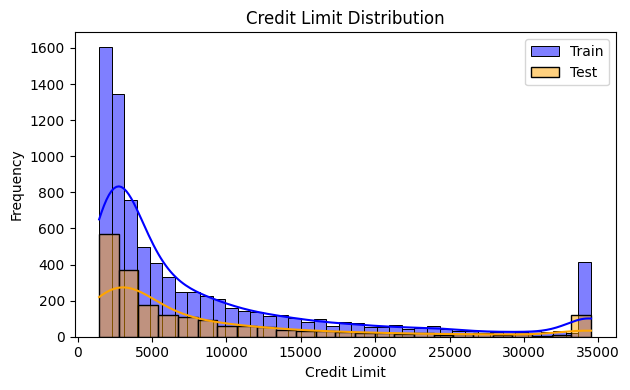

(8105, 18)


In [9]:
# Split the data
train_df, test_df = Preprocessing.split(df, 0.2, 42)

# Plot the distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(train_df['Credit_Limit'], kde=True, color='blue', label='Train')
sns.histplot(test_df['Credit_Limit'], kde=True, color='orange', label='Test')
plt.title('Credit Limit Distribution')
plt.xlabel('Credit Limit')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print(train_df.shape)


# Data Analisys


In [10]:
nan_counts = train_df.isna().sum().sort_values(ascending=False)
summary = pd.concat([train_df.info(), nan_counts], axis=0)
summary

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 4984 to 7270
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8105 non-null   float64
 1   Gender                    7947 non-null   float64
 2   Dependent_count           8105 non-null   int64  
 3   Education_Level           8105 non-null   int64  
 4   Marital_Status            6576 non-null   float64
 5   Income_Category           8105 non-null   int64  
 6   Card_Category             6586 non-null   float64
 7   Months_on_book            7921 non-null   float64
 8   Total_Relationship_Count  8087 non-null   float64
 9   Months_Inactive_12_mon    8105 non-null   int64  
 10  Contacts_Count_12_mon     8105 non-null   int64  
 11  Credit_Limit              8105 non-null   float64
 12  Total_Revolving_Bal       8105 non-null   int64  
 13  Total_Amt_Chng_Q4_Q1      8105 non-null   float64
 14  Total_Tran

Marital_Status              1529
Card_Category               1519
Months_on_book               184
Gender                       158
Total_Relationship_Count      18
Customer_Age                   0
Total_Revolving_Bal            0
Total_Ct_Chng_Q4_Q1            0
Total_Trans_Ct                 0
Total_Trans_Amt                0
Total_Amt_Chng_Q4_Q1           0
Months_Inactive_12_mon         0
Credit_Limit                   0
Contacts_Count_12_mon          0
Income_Category                0
Education_Level                0
Dependent_count                0
Avg_Utilization_Ratio          0
dtype: int64

In [11]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(7)

Total     %
Marital_Status             1529  18.9
Card_Category              1519  18.7
Months_on_book              184   2.3
Gender                      158   1.9
Total_Relationship_Count     18   0.2
Customer_Age                  0   0.0
Total_Revolving_Bal           0   0.0

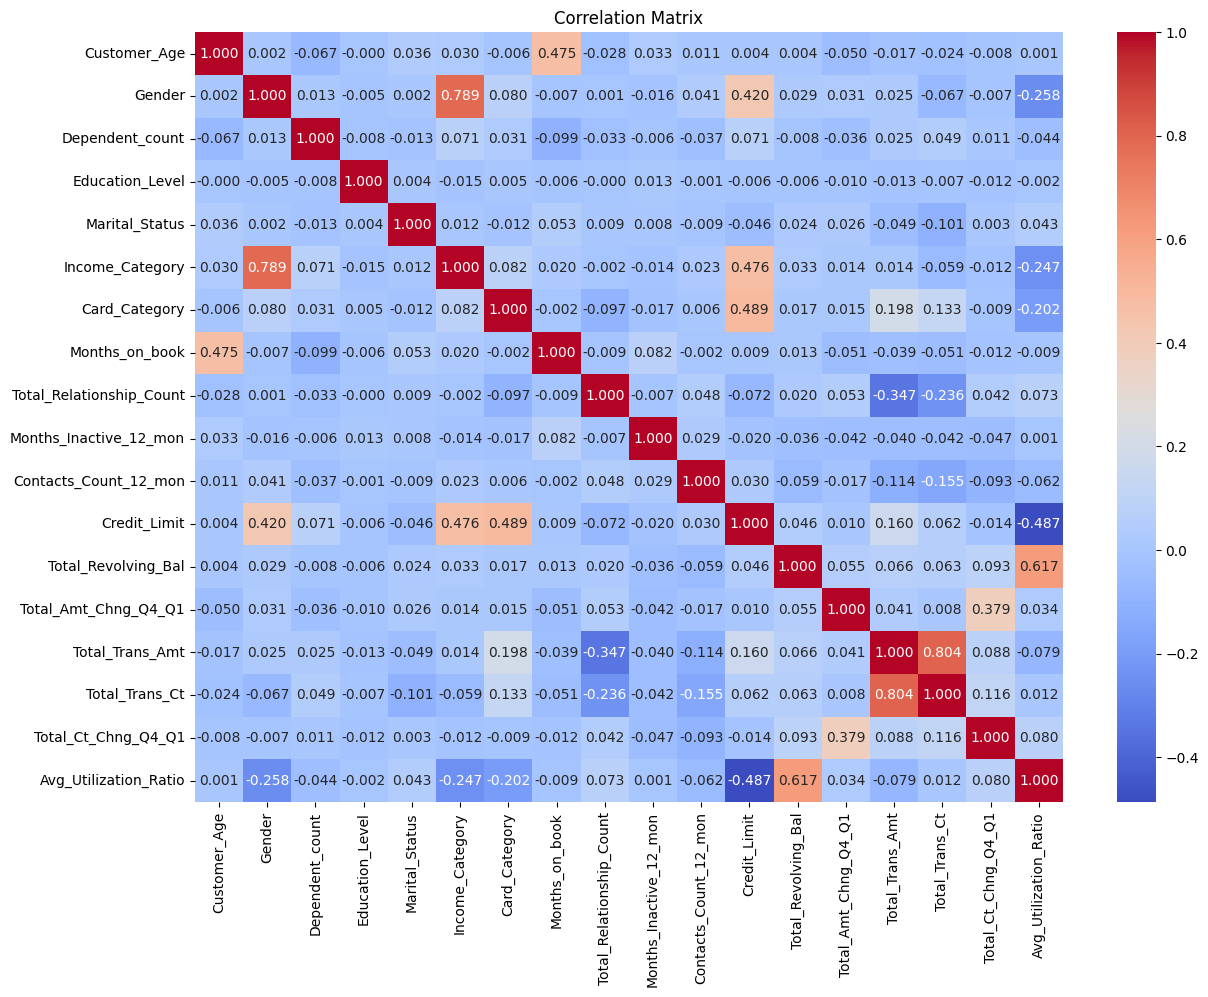

In [12]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Matrix')
plt.show()

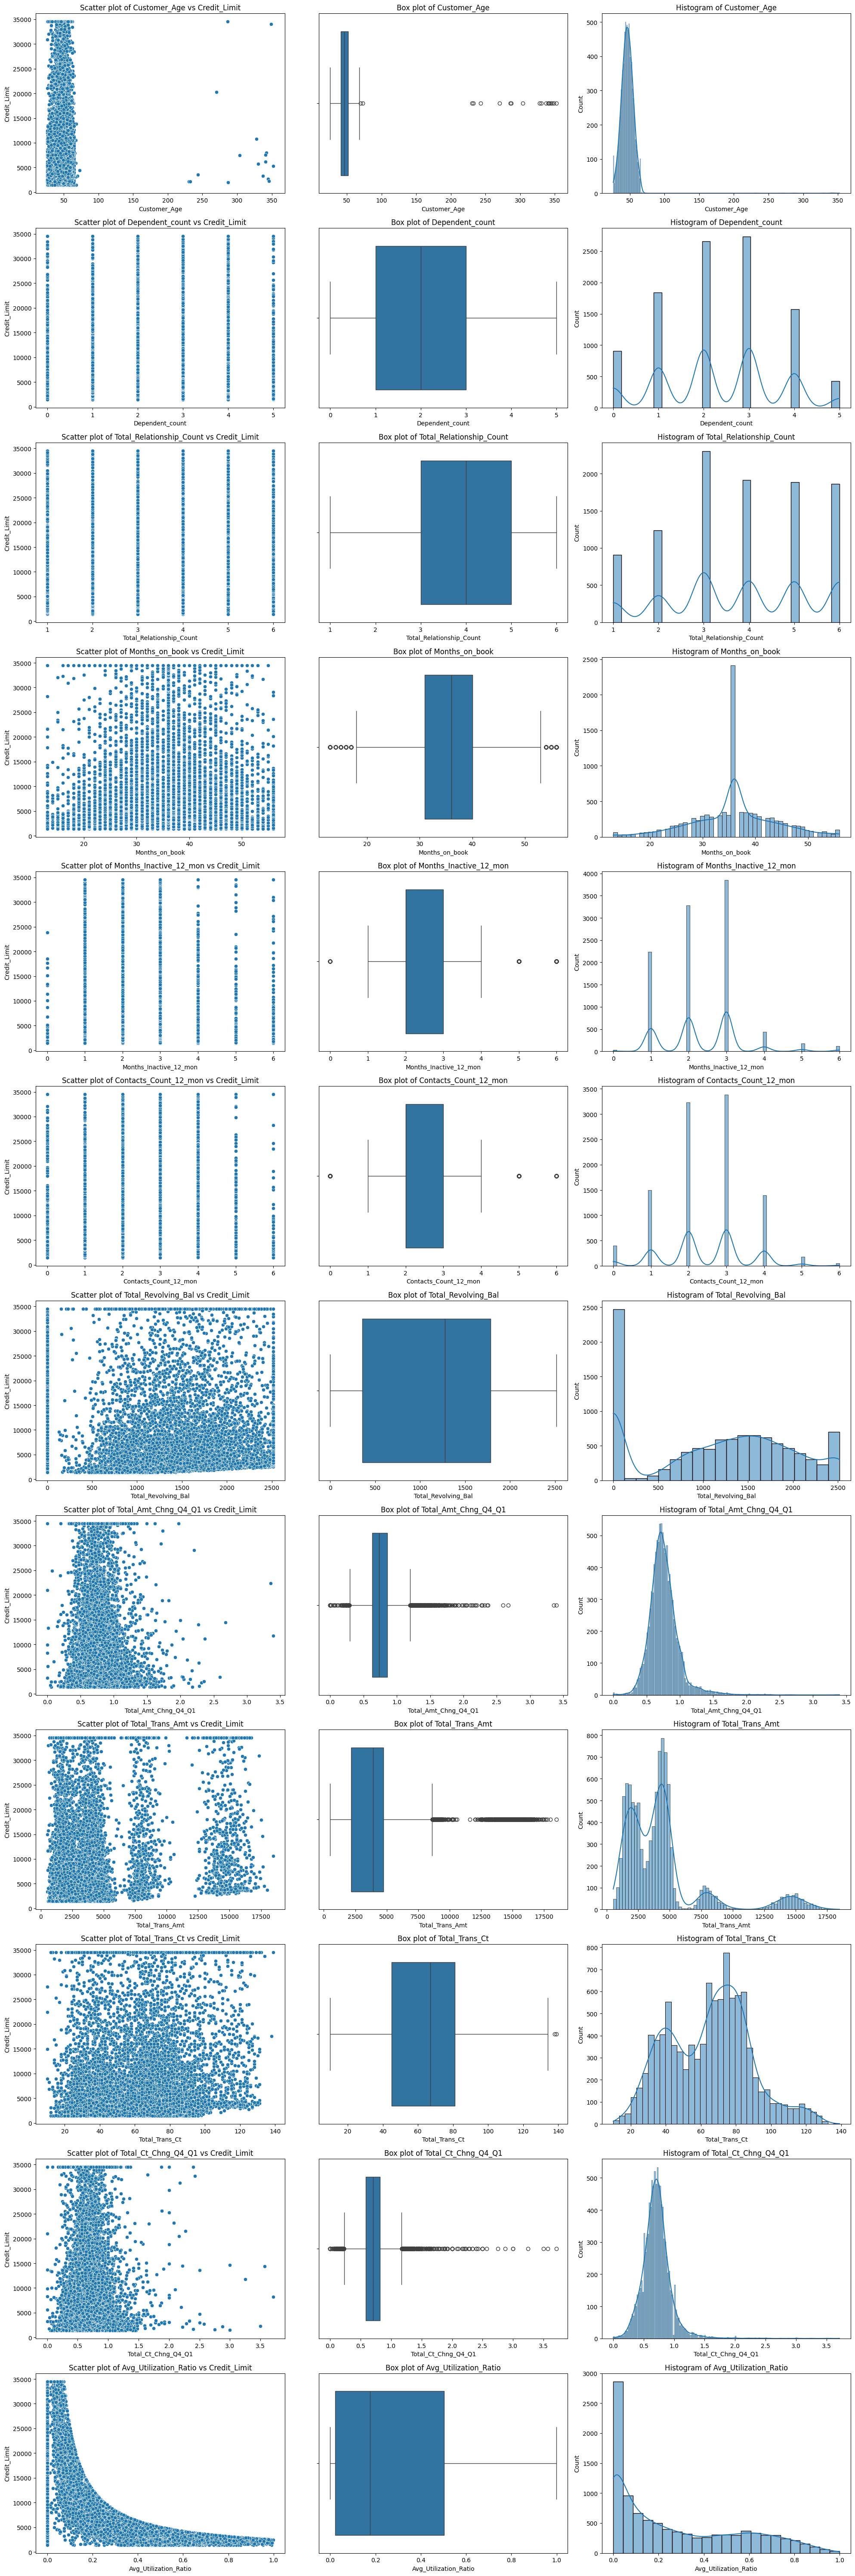

In [13]:
numeric_features = ['Customer_Age', 'Dependent_count', 'Total_Relationship_Count', 'Months_on_book', 
                    'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 
                    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 
                    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


plt.figure(figsize=(20, 5 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    # Scatter plot
    plt.subplot(len(numeric_features), 3, 3*i + 1)
    sns.scatterplot(data=df, x=feature, y='Credit_Limit')
    plt.title(f'Scatter plot of {feature} vs Credit_Limit')

    # Box plot to identify out
    plt.subplot(len(numeric_features), 3, 3*i + 2)
    sns.boxplot(x=df[feature])
    plt.title(f'Box plot of {feature}')

    # Histogram to understan distribiution
    plt.subplot(len(numeric_features), 3, 3*i + 3)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

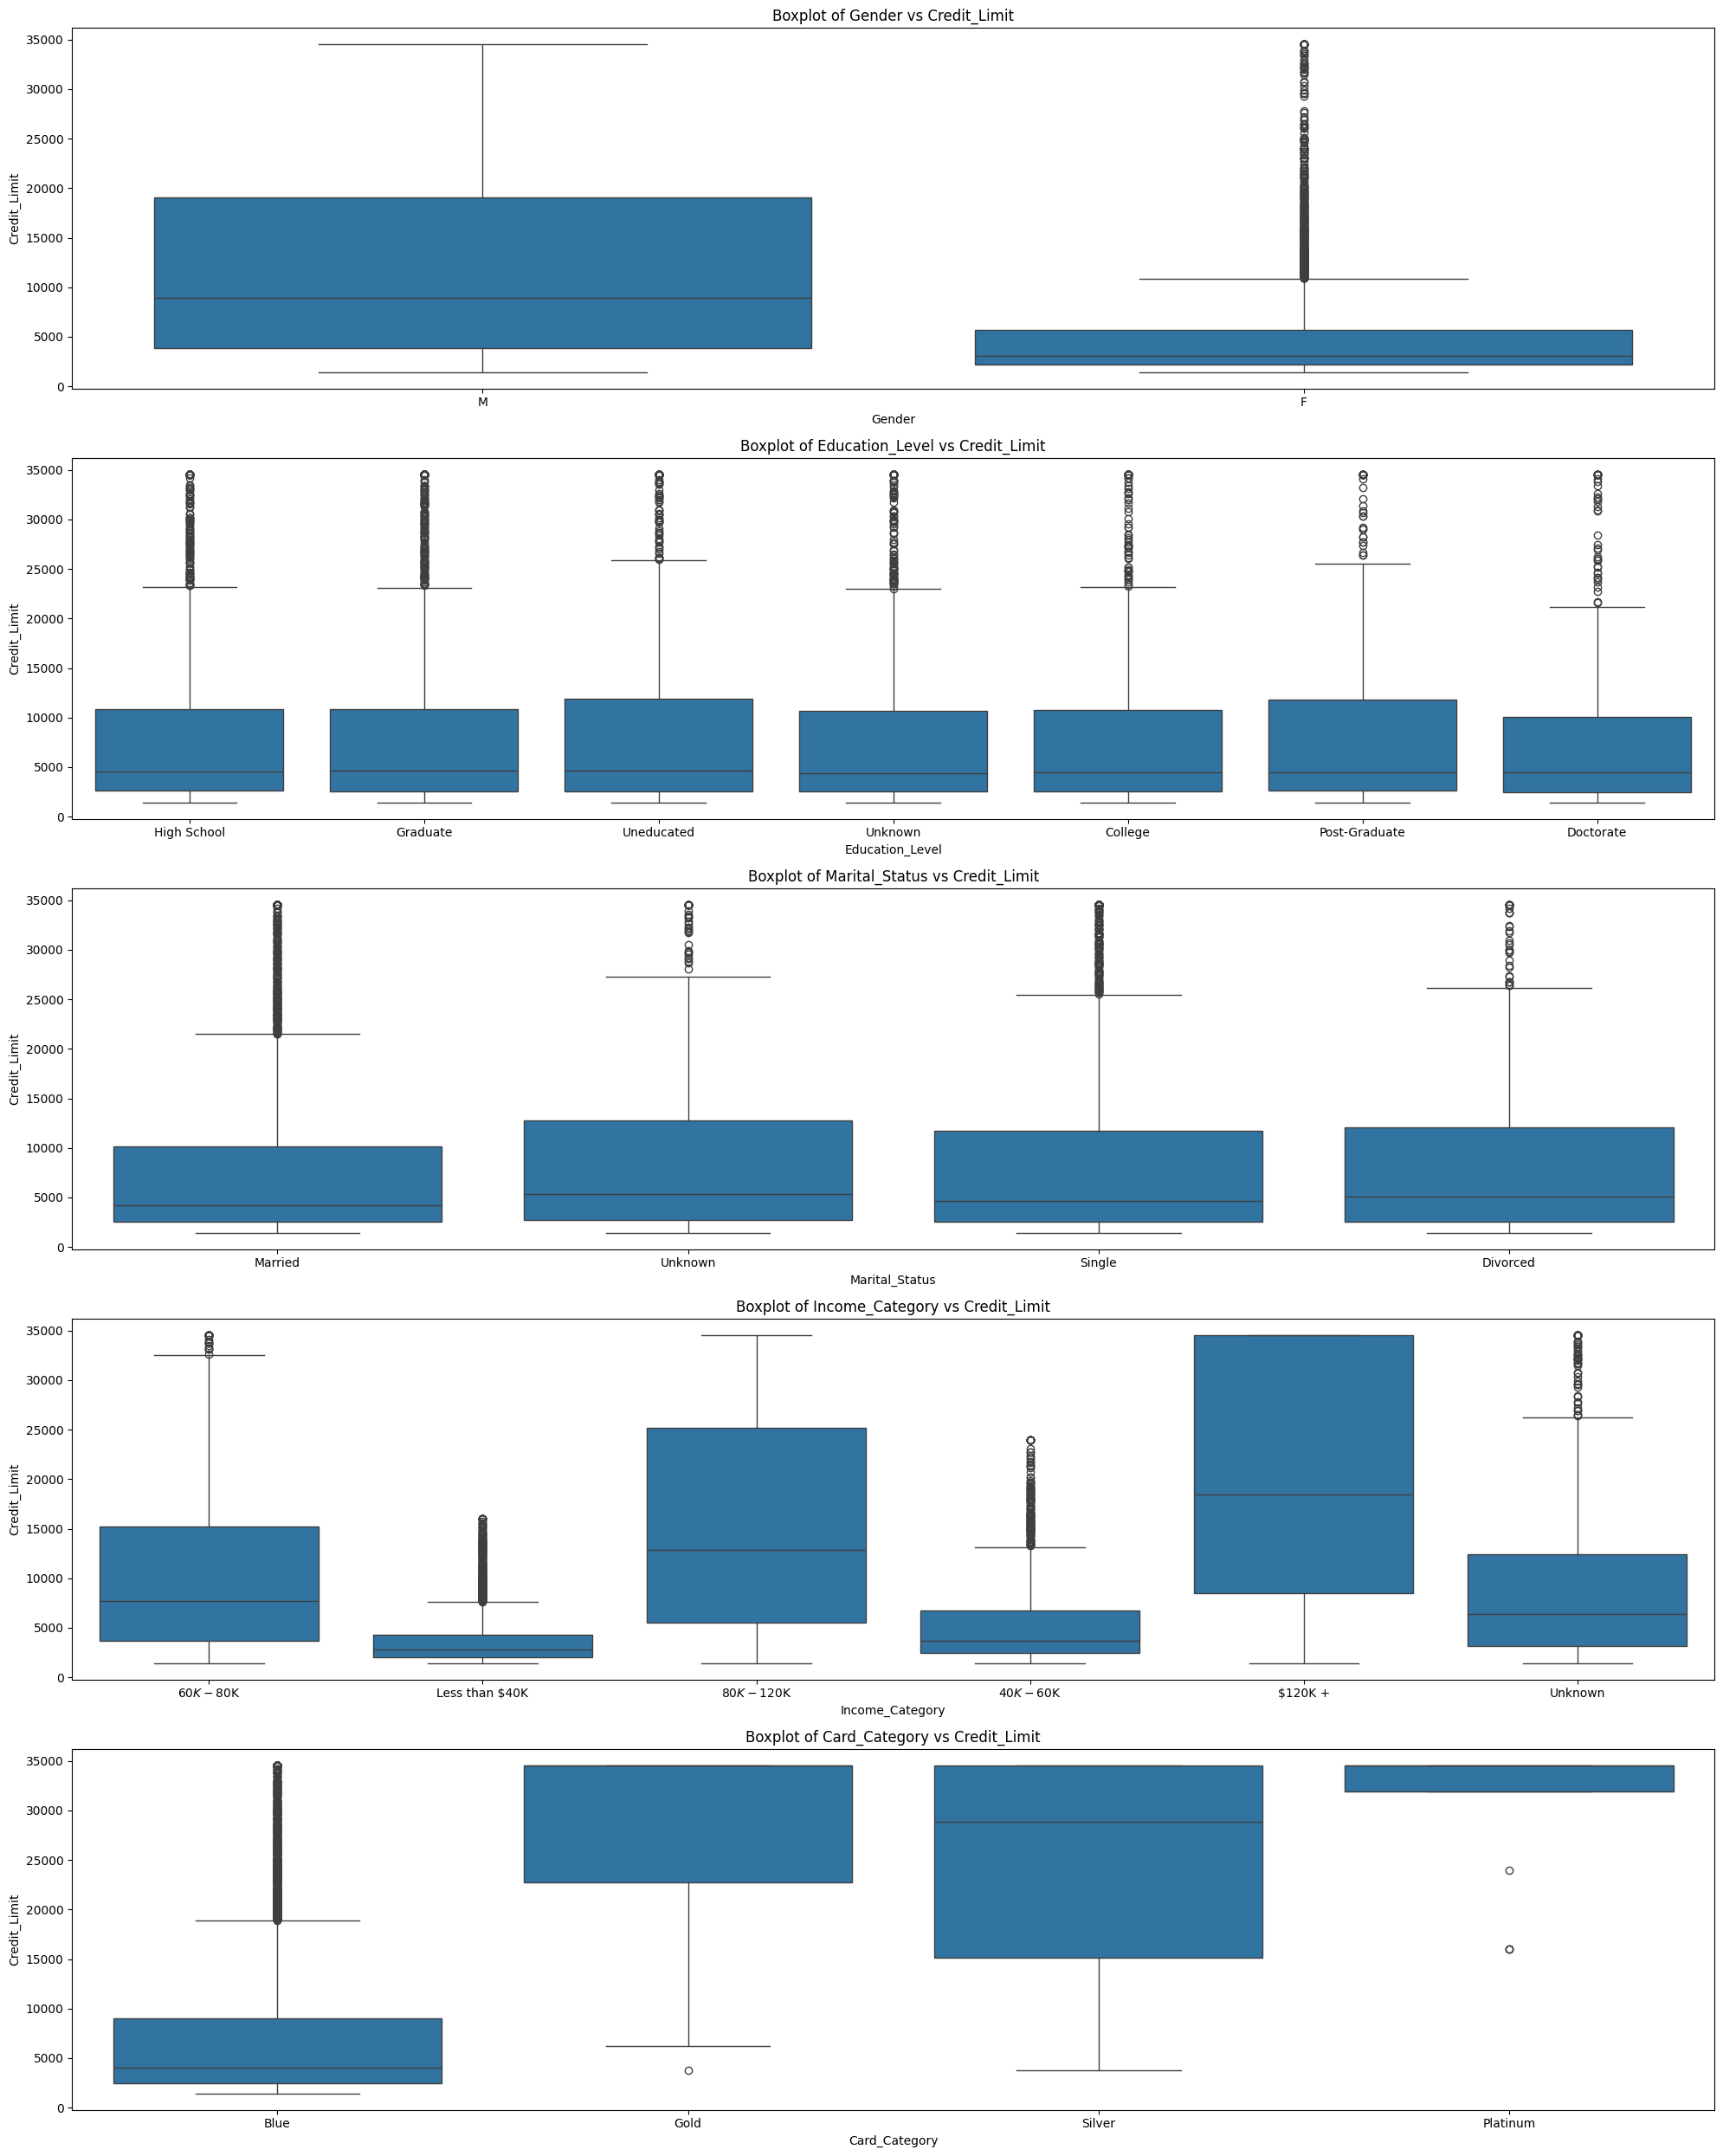

In [14]:
# Identify categorical features
categorical_features = df_copy.select_dtypes(include="object").columns

plt.figure(figsize=(20, 5 * len(categorical_features)))

for i, feature in enumerate(categorical_features):
    # Categorical plot
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.boxplot(data=df_copy, x=feature, y='Credit_Limit')
    plt.title(f'Boxplot of {feature} vs Credit_Limit')

plt.tight_layout()
plt.show()

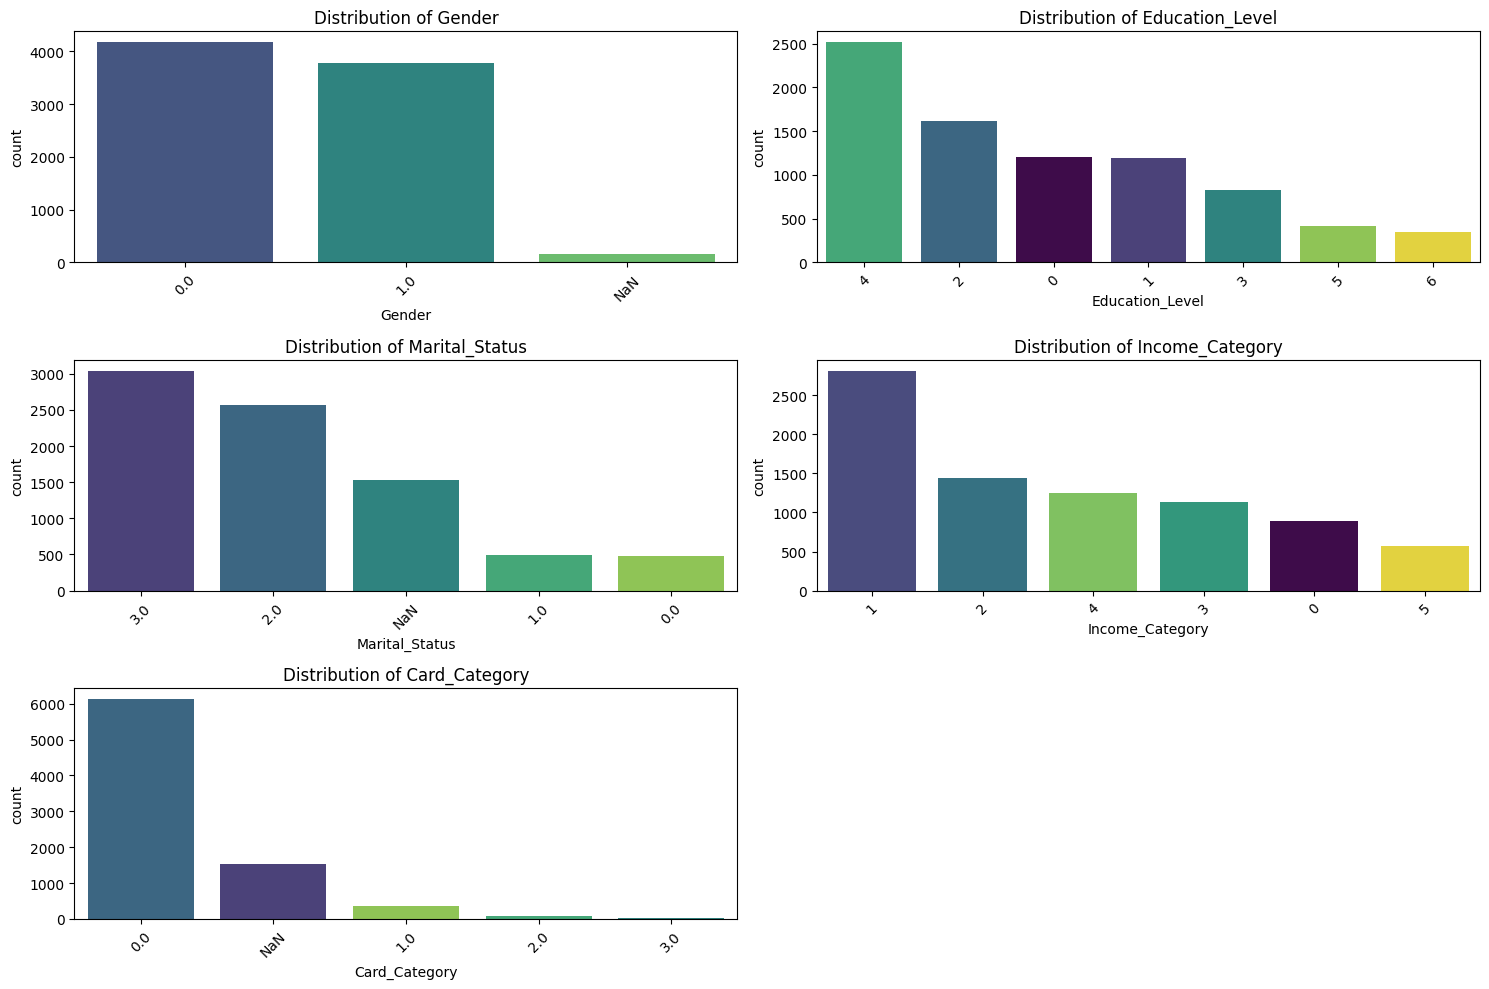

In [15]:
train_df_copy = train_df.copy()
categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
train_df_copy[categorical_features] = train_df_copy[categorical_features].fillna('NaN')

# Plot bar plots for each categorical feature including NaN values
plt.figure(figsize=(15, 10))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=train_df_copy, x=feature, hue=feature, order=train_df_copy[feature].value_counts().index, palette="viridis", legend=False)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

<Axes: >

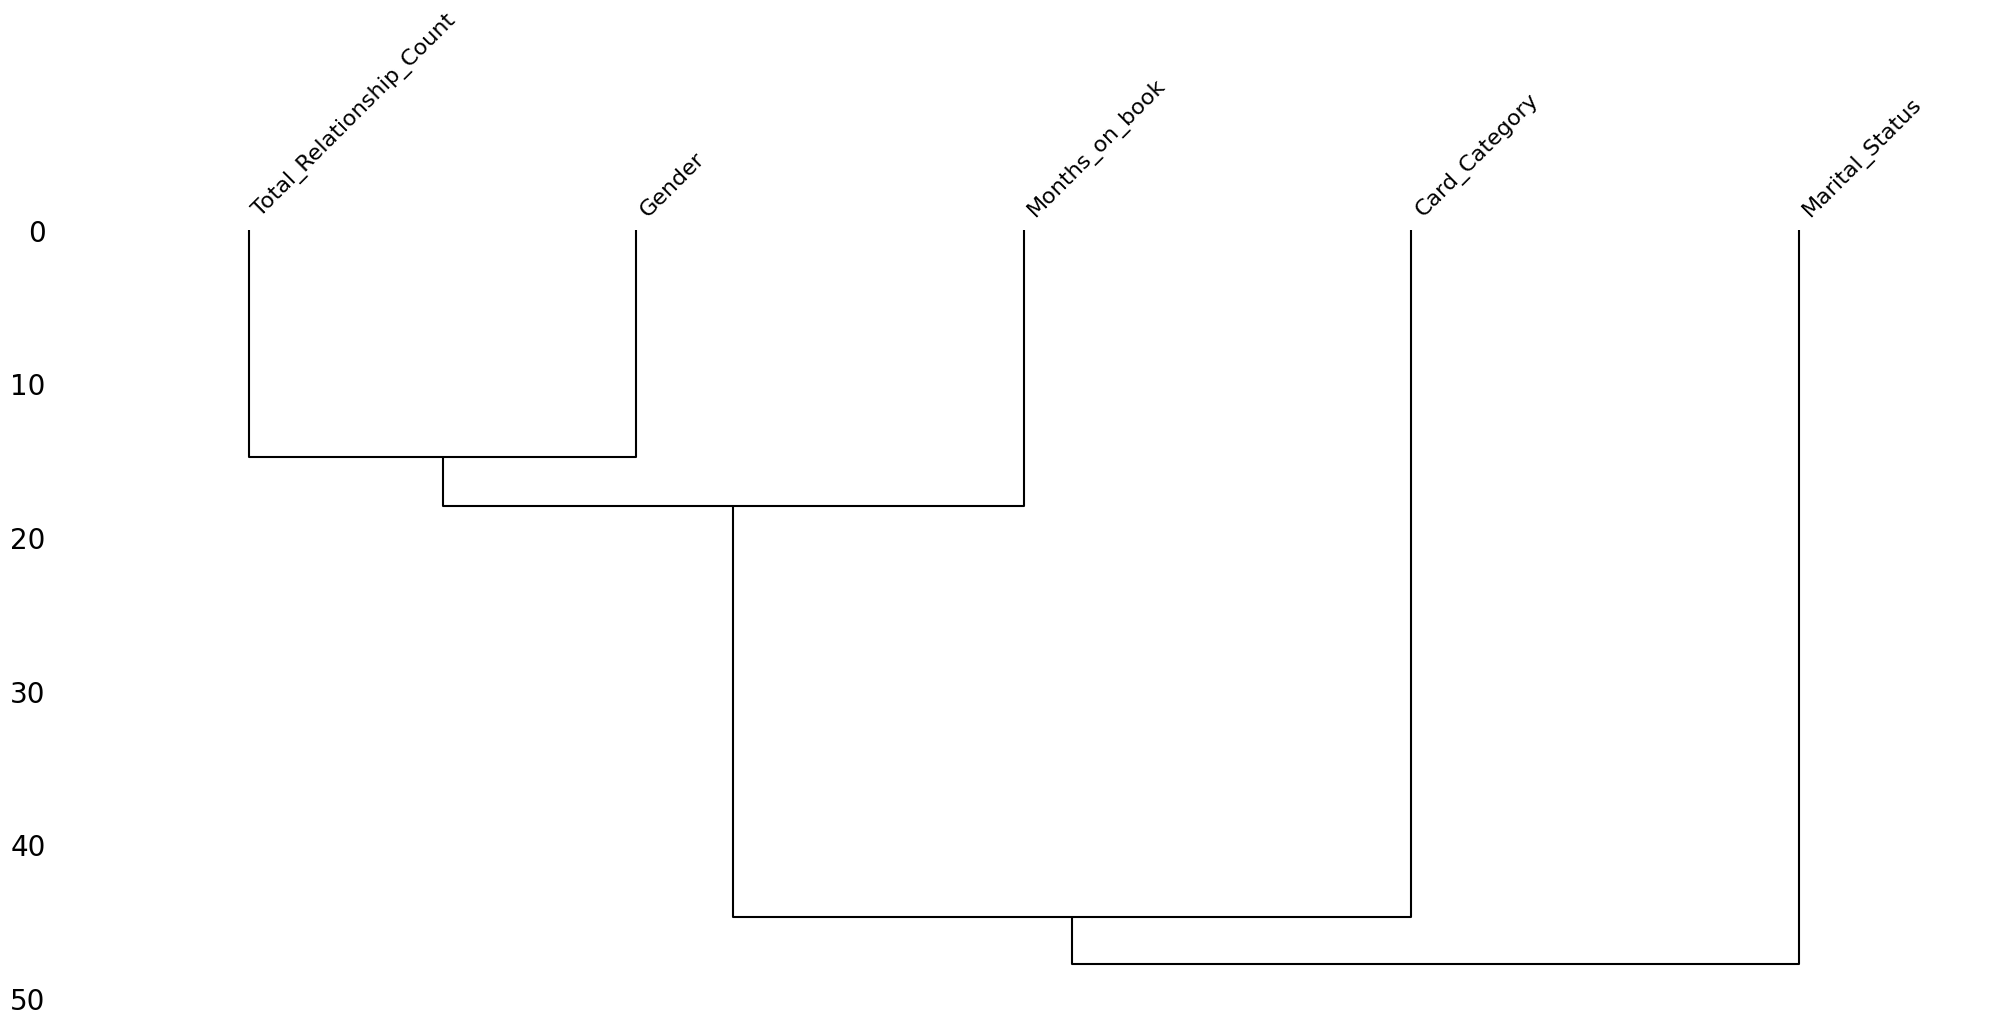

In [16]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
msno.dendrogram(df[missing_columns])


# Missing Values Treatment


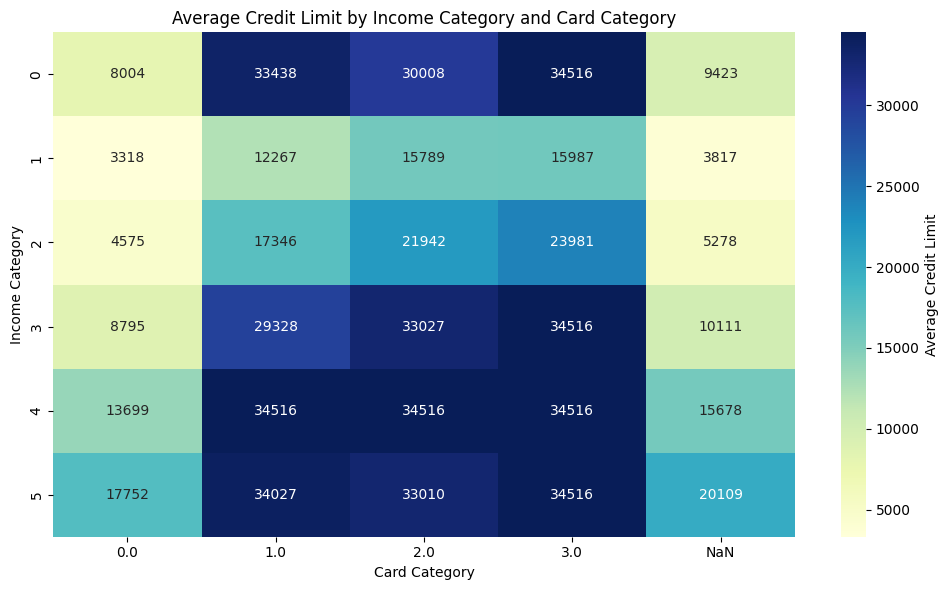

In [17]:
count_by_income_and_card = train_df_copy.groupby(["Income_Category", "Card_Category"]).size()

# Calculate average credit limit by income category and card category
average_limit_by_income_and_card = train_df_copy.groupby(["Income_Category", "Card_Category"])["Credit_Limit"].mean()

# Convert counts and average credit limit to DataFrames
count_df = count_by_income_and_card.reset_index(name='Count')
average_limit_df = average_limit_by_income_and_card.reset_index(name='Avg_Credit_Limit')

# Merge the two DataFrames on income category and card category
merged_df = pd.merge(count_df, average_limit_df, on=["Income_Category", "Card_Category"], how="left")

# Pivot the DataFrame
pivot_df = merged_df.pivot_table(index="Income_Category", columns="Card_Category", values=["Count", "Avg_Credit_Limit"], aggfunc="sum")

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df["Avg_Credit_Limit"], annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Average Credit Limit'})
plt.title('Average Credit Limit by Income Category and Card Category')
plt.xlabel('Card Category')
plt.ylabel('Income Category')
plt.tight_layout()
plt.show()

In [18]:
train_df['Card_Category'] = train_df['Card_Category'].fillna(0)
test_df['Card_Category'] = test_df['Card_Category'].fillna(0)

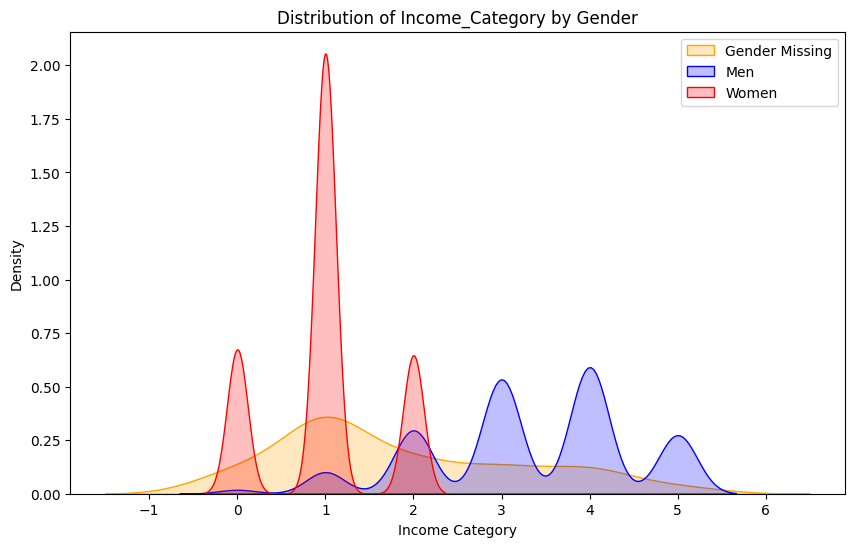

In [19]:
# Create three dataframes: one with missing gender, one for men, and one for women
df_nan_gender = train_df_copy[train_df_copy['Gender'] == 'NaN']
df_men = train_df_copy[(train_df_copy['Gender'] == 1)]
df_women = train_df_copy[(train_df_copy['Gender'] == 0)]

# Plot KDE plots for credit limit distribution for all groups
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_nan_gender['Income_Category'], label='Gender Missing', fill=True, color='orange')
sns.kdeplot(data=df_men['Income_Category'], label='Men', fill=True, color='blue')
sns.kdeplot(data=df_women['Income_Category'], label='Women', fill=True, color='red')
plt.title('Distribution of Income_Category by Gender')
plt.xlabel('Income Category')
plt.ylabel('Density')
plt.legend()
plt.show()


In [20]:
train_df.loc[train_df['Card_Category'].isin([3, 4, 5]) & train_df['Gender'].isnull(), 'Gender'] = 1
train_df.loc[train_df['Card_Category'].isin([0, 1, 2]) & train_df['Gender'].isnull(), 'Gender'] = 0

test_df.loc[test_df['Card_Category'].isin([3, 4, 5]) & test_df['Gender'].isnull(), 'Gender'] = 1
test_df.loc[test_df['Card_Category'].isin([0, 1, 2]) & test_df['Gender'].isnull(), 'Gender'] = 0

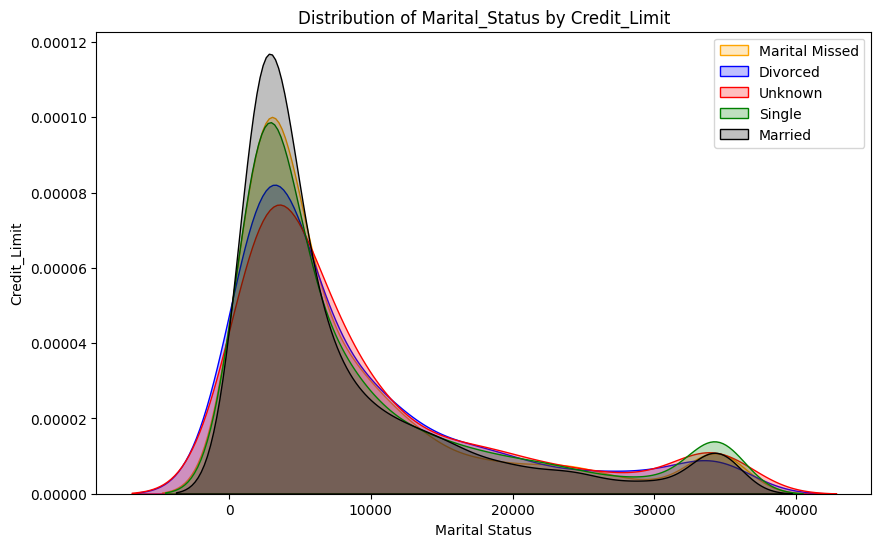

In [21]:
# Create three dataframes: one with missing gender, one for men, and one for women
df_nan_marital = train_df_copy[train_df_copy['Marital_Status'] == 'NaN']
df_divorce = train_df_copy[(train_df_copy['Marital_Status'] == 0)]
df_unknown = train_df_copy[(train_df_copy['Marital_Status'] == 1)]
df_single = train_df_copy[(train_df_copy['Marital_Status'] == 2)]
df_married = train_df_copy[(train_df_copy['Marital_Status'] == 3)]

# Plot KDE plots for credit limit distribution for all groups
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_nan_marital['Credit_Limit'], label='Marital Missed', fill=True, color='orange')
sns.kdeplot(data=df_divorce['Credit_Limit'], label='Divorced', fill=True, color='blue')
sns.kdeplot(data=df_unknown['Credit_Limit'], label='Unknown', fill=True, color='red')
sns.kdeplot(data=df_single['Credit_Limit'], label='Single', fill=True, color='green')
sns.kdeplot(data=df_married['Credit_Limit'], label='Married', fill=True, color='black')
plt.title('Distribution of Marital_Status by Credit_Limit')
plt.xlabel('Marital Status')
plt.ylabel('Credit_Limit')
plt.legend()
plt.show()


In [22]:
train_df['Marital_Status'] = train_df['Marital_Status'].fillna(2)
test_df['Marital_Status'] = test_df['Marital_Status'].fillna(2)

In [23]:
train_df = Preprocessing.tree_imputation(train_df)
test_df = Preprocessing.tree_imputation(test_df)

train_df.head()

Customer_Age  Gender  Dependent_count  Education_Level  Marital_Status  \
4984          52.0     0.0                3                4             3.0   
3550          52.0     0.0                2                2             2.0   
1937          34.0     1.0                2                4             2.0   
4480          50.0     0.0                4                2             3.0   
8553          50.0     0.0                3                2             2.0   

      Income_Category  Card_Category  Months_on_book  \
4984                1            0.0            39.0   
3550                1            0.0            40.0   
1937                4            0.0            29.0   
4480                2            0.0            36.0   
8553                1            0.0            42.0   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
4984                       4.0                       3                      3   
3550                       3.0                       1                      3   
1937                       3.0                       1                      3   
4480                       6.0                       1                      1   
8553                       1.0                       3                      2   

      Credit_Limit  Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  \
4984        2001.0                  909                 0.772   
3550        1960.0                 1428                 0.570   
1937       13395.0                 1678                 1.006   
4480        1479.0                 1004                 0.827   
8553        1477.0                    0                 0.685   

      Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
4984             4238              63                0.800   
3550             3782              64                0.641   
1937             2650              69                0.865   
4480             5116              75                0.974   
8553             4680              80                0.778   

      Avg_Utilization_Ratio  
4984                  0.454  
3550                  0.729  
1937                  0.125  
4480                  0.679  
8553                  0.000

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 4984 to 7270
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8105 non-null   float64
 1   Gender                    8105 non-null   float64
 2   Dependent_count           8105 non-null   int64  
 3   Education_Level           8105 non-null   int64  
 4   Marital_Status            8105 non-null   float64
 5   Income_Category           8105 non-null   int64  
 6   Card_Category             8105 non-null   float64
 7   Months_on_book            8105 non-null   float64
 8   Total_Relationship_Count  8105 non-null   float64
 9   Months_Inactive_12_mon    8105 non-null   int64  
 10  Contacts_Count_12_mon     8105 non-null   int64  
 11  Credit_Limit              8105 non-null   float64
 12  Total_Revolving_Bal       8105 non-null   int64  
 13  Total_Amt_Chng_Q4_Q1      8105 non-null   float64
 14  Total_Tran

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2027 entries, 7658 to 3739
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              2027 non-null   float64
 1   Gender                    2027 non-null   float64
 2   Dependent_count           2027 non-null   int64  
 3   Education_Level           2027 non-null   int64  
 4   Marital_Status            2027 non-null   float64
 5   Income_Category           2027 non-null   int64  
 6   Card_Category             2027 non-null   float64
 7   Months_on_book            2027 non-null   float64
 8   Total_Relationship_Count  2027 non-null   float64
 9   Months_Inactive_12_mon    2027 non-null   int64  
 10  Contacts_Count_12_mon     2027 non-null   int64  
 11  Credit_Limit              2027 non-null   float64
 12  Total_Revolving_Bal       2027 non-null   int64  
 13  Total_Amt_Chng_Q4_Q1      2027 non-null   float64
 14  Total_Tran


# Outlier Detection and Treatment


In [26]:
train_df.describe().T

count         mean          std     min       25%  \
Customer_Age              8105.0    46.795802    14.377782    26.0    41.000   
Gender                    8105.0     0.465762     0.498857     0.0     0.000   
Dependent_count           8105.0     2.349291     1.297739     0.0     1.000   
Education_Level           8105.0     2.600864     1.691823     0.0     1.000   
Marital_Status            8105.0     2.198396     0.794150     0.0     2.000   
Income_Category           8105.0     2.094139     1.474327     0.0     1.000   
Card_Category             8105.0     0.069340     0.306444     0.0     0.000   
Months_on_book            8105.0    35.904281     7.987909    13.0    31.000   
Total_Relationship_Count  8105.0     3.804059     1.556784     1.0     3.000   
Months_Inactive_12_mon    8105.0     2.341888     1.007721     0.0     2.000   
Contacts_Count_12_mon     8105.0     2.455398     1.100913     0.0     2.000   
Credit_Limit              8105.0  8602.754127  9051.970024  1438.3  2537.000   
Total_Revolving_Bal       8105.0  1166.640592   814.016266     0.0   451.000   
Total_Amt_Chng_Q4_Q1      8105.0     0.759599     0.216736     0.0     0.631   
Total_Trans_Amt           8105.0  4417.966440  3397.459451   510.0  2164.000   
Total_Trans_Ct            8105.0    64.990130    23.475090    10.0    45.000   
Total_Ct_Chng_Q4_Q1       8105.0     0.711974     0.238704     0.0     0.583   
Avg_Utilization_Ratio     8105.0     0.276807     0.275700     0.0     0.026   

                               50%        75%           max  
Customer_Age                46.000     52.000    352.330517  
Gender                       0.000      1.000      1.000000  
Dependent_count              2.000      3.000      5.000000  
Education_Level              3.000      4.000      6.000000  
Marital_Status               2.000      3.000      3.000000  
Income_Category              2.000      3.000      5.000000  
Card_Category                0.000      0.000      3.000000  
Months_on_book              36.000     40.000     56.000000  
Total_Relationship_Count     4.000      5.000      6.000000  
Months_Inactive_12_mon       2.000      3.000      6.000000  
Contacts_Count_12_mon        2.000      3.000      6.000000  
Credit_Limit              4552.000  11062.000  34516.000000  
Total_Revolving_Bal       1279.000   1785.000   2517.000000  
Total_Amt_Chng_Q4_Q1         0.736      0.859      2.675000  
Total_Trans_Amt           3913.000   4751.000  17744.000000  
Total_Trans_Ct              68.000     81.000    139.000000  
Total_Ct_Chng_Q4_Q1          0.702      0.818      3.714000  
Avg_Utilization_Ratio        0.178      0.507      0.999000

In [27]:
df_copy.select_dtypes(exclude="object").columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [28]:
outlier_detection_columns = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

In [29]:
Preprocessing.treat_outlier(train_df, outlier_detection_columns)

Customer_Age  Gender  Dependent_count  Education_Level  Marital_Status  \
4984          52.0     0.0                3              4.0             3.0   
3550          52.0     0.0                2              2.0             2.0   
1937          34.0     1.0                2              4.0             2.0   
4480          50.0     0.0                4              2.0             3.0   
8553          50.0     0.0                3              2.0             2.0   
...            ...     ...              ...              ...             ...   
5734          44.0     0.0                1              4.0             2.0   
5191          53.0     0.0                3              2.0             0.0   
5390          42.0     0.0                4              4.0             1.0   
860           40.0     1.0                3              0.0             2.0   
7270          53.0     1.0                4              2.0             2.0   

      Income_Category  Card_Category  Months_on_book  \
4984              1.0            0.0            39.0   
3550              1.0            0.0            40.0   
1937              4.0            0.0            29.0   
4480              2.0            0.0            36.0   
8553              1.0            0.0            42.0   
...               ...            ...             ...   
5734              2.0            0.0            38.0   
5191              0.0            0.0            36.0   
5390              1.0            0.0            32.0   
860               2.0            0.0            28.0   
7270              3.0            0.0            49.0   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
4984                       4.0                       3                      3   
3550                       3.0                       1                      3   
1937                       3.0                       1                      3   
4480                       6.0                       1                      1   
8553                       1.0                       3                      2   
...                        ...                     ...                    ...   
5734                       3.0                       2                      5   
5191                       4.0                       3                      6   
5390                       3.0                       1                      2   
860                        4.0                       1                      1   
7270                       5.0                       1                      2   

      Credit_Limit  Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  \
4984        2001.0                  909                 0.772   
3550        1960.0                 1428                 0.570   
1937       13395.0                 1678                 1.006   
4480        1479.0                 1004                 0.827   
8553        1477.0                    0                 0.685   
...            ...                  ...                   ...   
5734        4142.0                 2517                 0.809   
5191        7939.0                    0                 0.551   
5390        2314.0                 1547                 0.804   
860         3563.0                 1707                 0.506   
7270        3858.0                    0                 0.670   

      Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
4984             4238              63                0.800   
3550             3782              64                0.641   
1937             2650              69                0.865   
4480             5116              75                0.974   
8553             4680              80                0.778   
...               ...             ...                  ...   
5734             2104              44                0.833   
5191             2269              42                0.312   
5390             4678              74                1.000  

In [30]:
# def wisker(column):
#     q1, q3 = np.percentile(column, [25, 75])
#     iqr = q3 - q1
#     lw = q1 - 0.5 * iqr
#     uw = q3 + 0.5 * iqr
#     return lw, uw

# def treat_outlier(data, wisker_columns):
#     for col in wisker_columns:
#         lw, uw = wisker(data[col])
#         outliers = (data[col] < lw) | (data[col] > uw)
#         # train_df.loc[outliers, col] = np.nan
#         data = data[~outliers]
#         return data


In [31]:
# Detect ages greater than 125 and set them to NaN
train_df['Customer_Age'] = train_df['Customer_Age'].apply(lambda x: np.nan if x > 125 else x)
test_df['Customer_Age'] = test_df['Customer_Age'].apply(lambda x: np.nan if x > 125 else x)

# Impute the missing values
imputer = SimpleImputer(strategy='mean')
train_df['Customer_Age'] = imputer.fit_transform(train_df[['Customer_Age']])
test_df['Customer_Age'] = imputer.transform(test_df[['Customer_Age']])

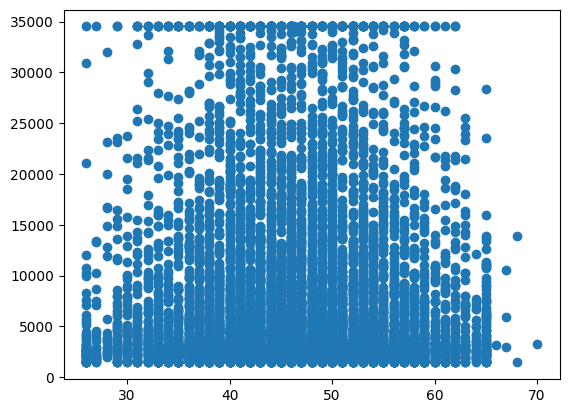

In [32]:
plt.scatter(x='Customer_Age', y='Credit_Limit', data=train_df)

In [33]:

def lof(data, test, feature_x, feature_y, n=5, c=0.05):
    # Extract the features for LOF
    X = data[[feature_x, feature_y]]
    T = test[[feature_x, feature_y]]
    
    # Fit the LOF model
    lof = LocalOutlierFactor(n_neighbors=n, contamination=c)
    lof.fit(X)
    data['outlier'] = lof.fit_predict(X)
    test['outlier'] = lof.fit_predict(T)
    
    # Identify the outliers
    outliers = data[data['outlier'] == -1]
    inliers = data[data['outlier'] == 1]

    outliers_test = test[test['outlier'] == -1]
    inliers_test = test[test['outlier'] == 1]
    
    print("#outlier detected : ", len(outliers))
    
    # Plot scatter plot with outliers highlighted in red
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature_x, y=feature_y, data=inliers, label='Inliers')
    sns.scatterplot(x=outliers[feature_x], y=outliers[feature_y], color='red', s=100, label='Outliers')
    plt.title(f'Scatter plot of {feature_x} vs {feature_y} with Outliers')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend()
    plt.show()

    return data, test


#outlier detected :  30


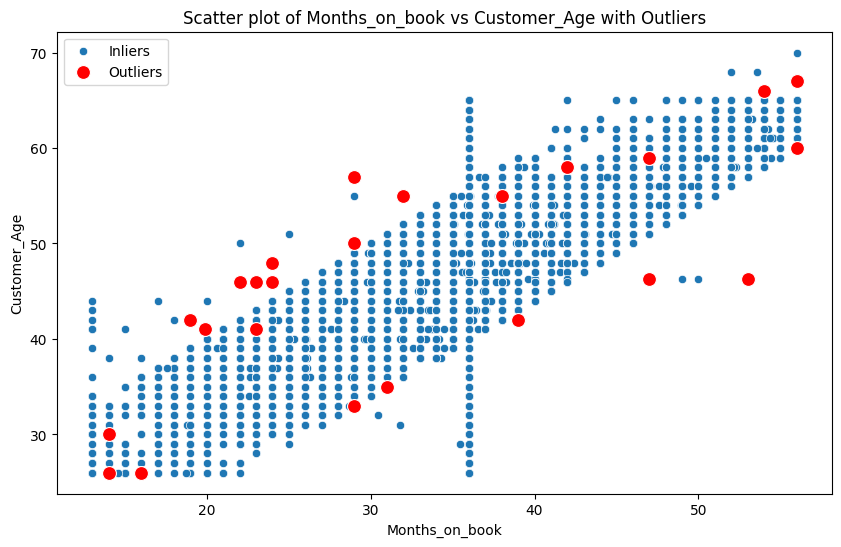

In [34]:
outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Months_on_book', 'Customer_Age', 5, 0.006)

In [35]:
train_df = train_df[outlier_train['outlier'] != -1]
test_df = test_df[outlier_test['outlier'] != -1]

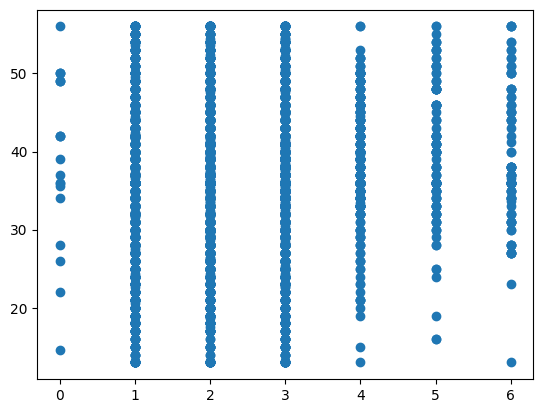

In [36]:
plt.scatter(x='Months_Inactive_12_mon', y='Months_on_book', data=train_df)

#outlier detected :  34


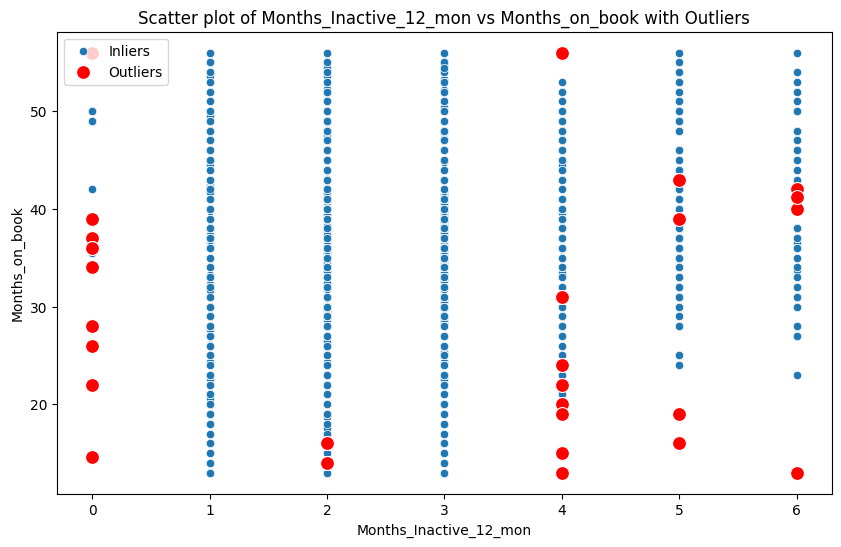

In [37]:
outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Months_Inactive_12_mon', 'Months_on_book', 5, 0.005)

In [38]:
train_df = train_df[outlier_train['outlier'] != -1]
test_df = test_df[outlier_test['outlier'] != -1]

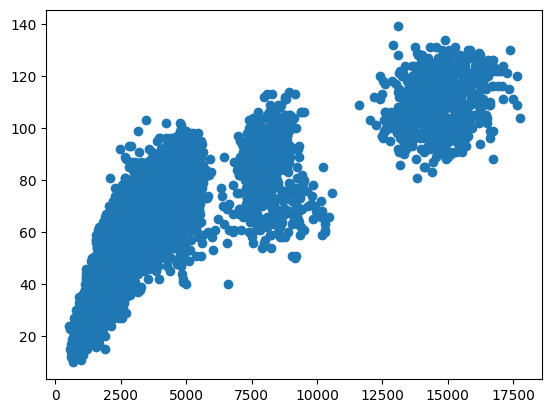

In [39]:
plt.scatter(x='Total_Trans_Amt', y='Total_Trans_Ct', data=train_df)

#outlier detected :  81


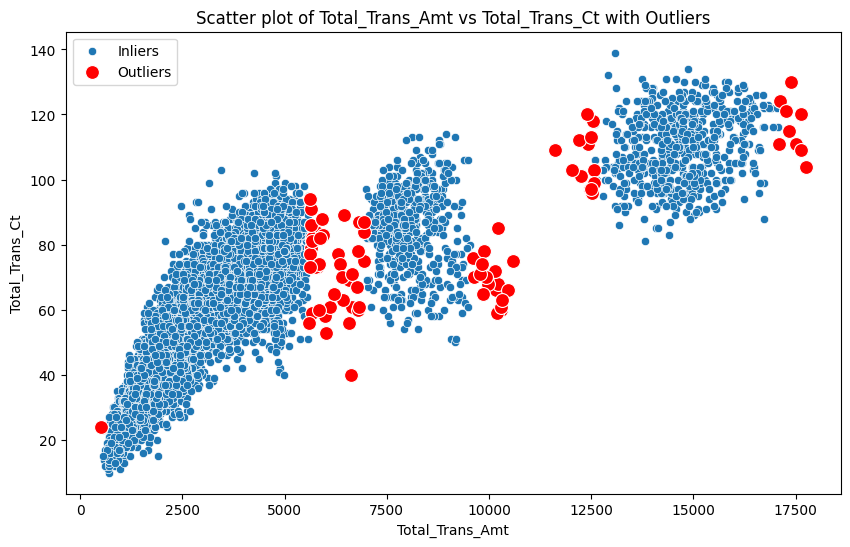

In [40]:
outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Total_Trans_Amt', 'Total_Trans_Ct', 100, 0.01)

In [41]:
train_df = train_df[outlier_train['outlier'] != -1]
test_df = test_df[outlier_test['outlier'] != -1]

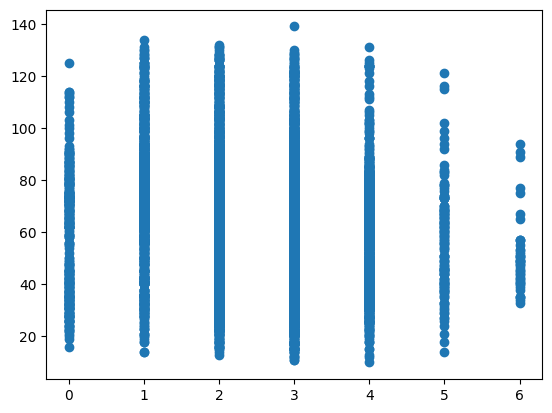

In [42]:
plt.scatter(x='Contacts_Count_12_mon', y='Total_Trans_Ct', data=train_df)

#outlier detected :  34


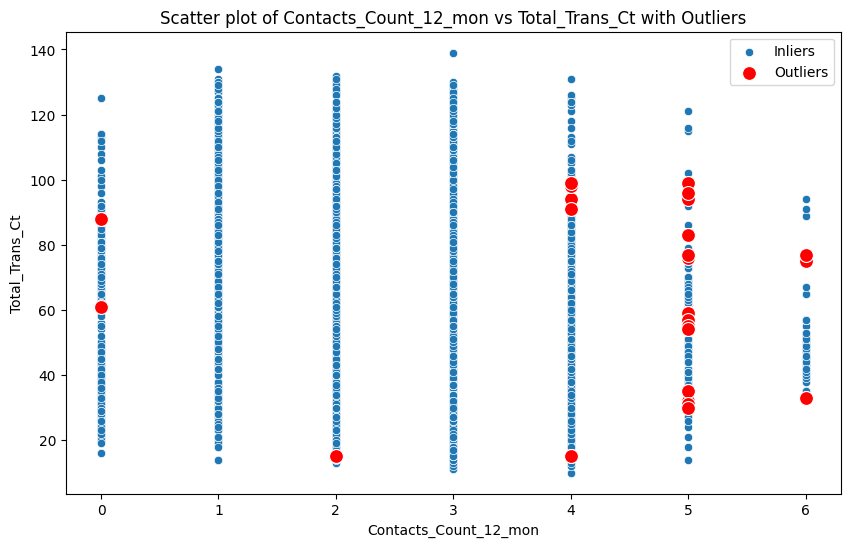

In [43]:
outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Contacts_Count_12_mon', 'Total_Trans_Ct', 10, 0.005)

In [44]:
train_df = train_df[outlier_train['outlier'] != -1]
test_df = test_df[outlier_test['outlier'] != -1]

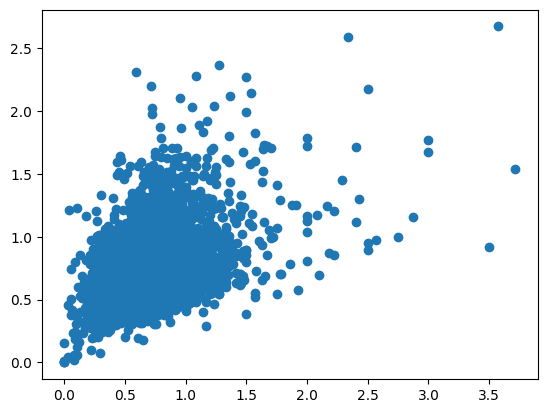

In [45]:
plt.scatter(x='Total_Ct_Chng_Q4_Q1', y='Total_Amt_Chng_Q4_Q1', data=train_df)

#outlier detected :  119


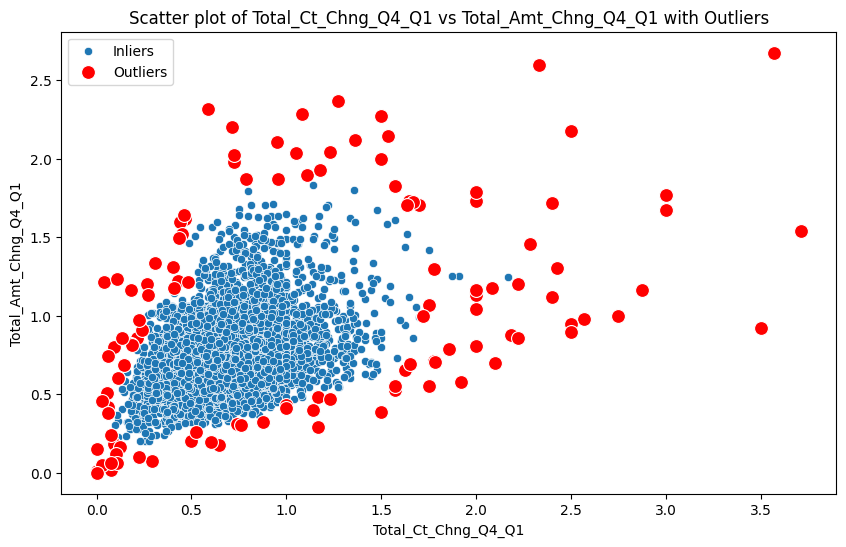

In [46]:
outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Total_Ct_Chng_Q4_Q1', 'Total_Amt_Chng_Q4_Q1', 50, 0.015)

In [47]:
train_df = train_df[outlier_train['outlier'] != -1]
test_df = test_df[outlier_test['outlier'] != -1]

In [48]:
print(train_df.shape)

(7807, 18)


In [49]:
train_df.describe().T

count         mean          std       min  \
Customer_Age              7807.0    46.283693     7.942995    26.000   
Gender                    7807.0     0.463430     0.498693     0.000   
Dependent_count           7807.0     2.353273     1.293655     0.000   
Education_Level           7807.0     2.597925     1.693338     0.000   
Marital_Status            7807.0     2.198027     0.793570     0.000   
Income_Category           7807.0     2.090047     1.473034     0.000   
Card_Category             7807.0     0.054566     0.227146     0.000   
Months_on_book            7807.0    35.943234     7.894505    13.000   
Total_Relationship_Count  7807.0     3.812079     1.555743     1.000   
Months_Inactive_12_mon    7807.0     2.337902     1.000424     0.000   
Contacts_Count_12_mon     7807.0     2.445882     1.092030     0.000   
Credit_Limit              7807.0  8538.602997  9005.688475  1438.300   
Total_Revolving_Bal       7807.0  1168.751761   811.631116     0.000   
Total_Amt_Chng_Q4_Q1      7807.0     0.755334     0.196850     0.198   
Total_Trans_Amt           7807.0  4411.222877  3359.877827   563.000   
Total_Trans_Ct            7807.0    65.375560    23.218760    10.000   
Total_Ct_Chng_Q4_Q1       7807.0     0.704875     0.203572     0.091   
Avg_Utilization_Ratio     7807.0     0.278588     0.276143     0.000   

                               25%       50%         75%        max  
Customer_Age                41.000    46.000     52.0000     70.000  
Gender                       0.000     0.000      1.0000      1.000  
Dependent_count              1.000     2.000      3.0000      5.000  
Education_Level              1.000     3.000      4.0000      6.000  
Marital_Status               2.000     2.000      3.0000      3.000  
Income_Category              1.000     2.000      3.0000      5.000  
Card_Category                0.000     0.000      0.0000      1.000  
Months_on_book              32.000    36.000     40.0000     56.000  
Total_Relationship_Count     3.000     4.000      5.0000      6.000  
Months_Inactive_12_mon       2.000     2.000      3.0000      6.000  
Contacts_Count_12_mon        2.000     2.000      3.0000      6.000  
Credit_Limit              2525.000  4503.000  10923.5000  34516.000  
Total_Revolving_Bal        477.500  1280.000   1784.0000   2517.000  
Total_Amt_Chng_Q4_Q1         0.631     0.735      0.8560      1.831  
Total_Trans_Amt           2196.500  3924.000   4738.5000  17064.000  
Total_Trans_Ct              46.000    68.000     81.0000    139.000  
Total_Ct_Chng_Q4_Q1          0.583     0.700      0.8155      2.167  
Avg_Utilization_Ratio        0.028     0.181      0.5110      0.995

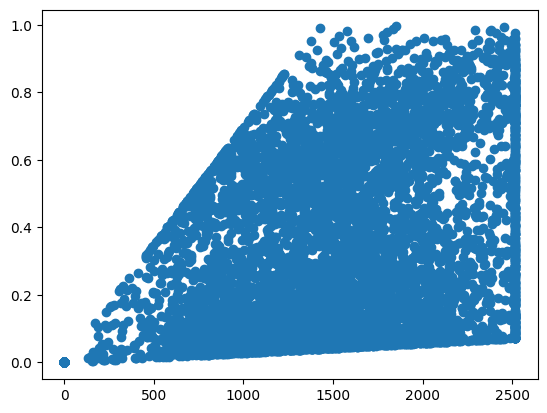

In [50]:
plt.scatter(x='Total_Revolving_Bal', y='Avg_Utilization_Ratio', data=train_df)

#outlier detected :  391


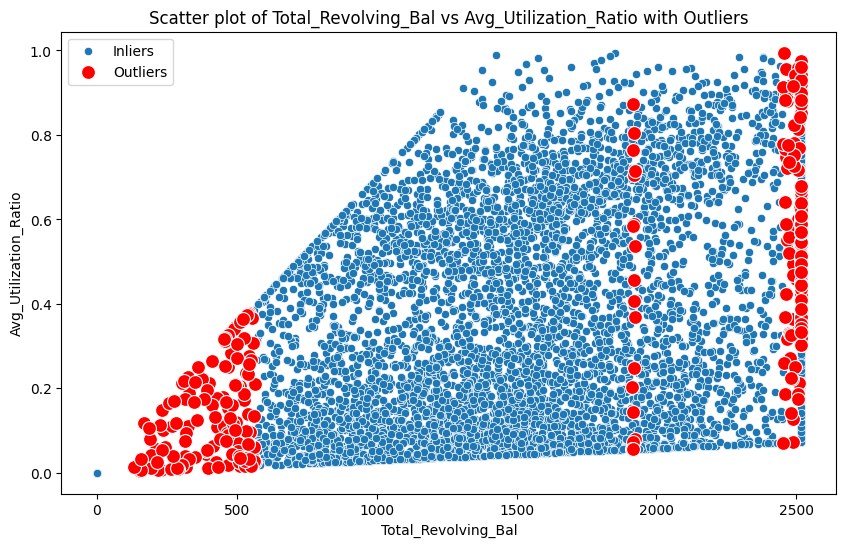

In [51]:
outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Total_Revolving_Bal', 'Avg_Utilization_Ratio', 100, 0.05)

In [52]:
train_df = train_df[outlier_train['outlier'] != -1]
test_df = test_df[outlier_test['outlier'] != -1]

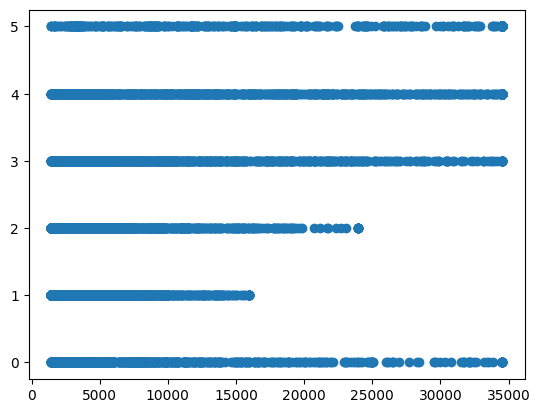

In [53]:
plt.scatter(x='Credit_Limit', y='Income_Category', data=train_df)

#outlier detected :  371


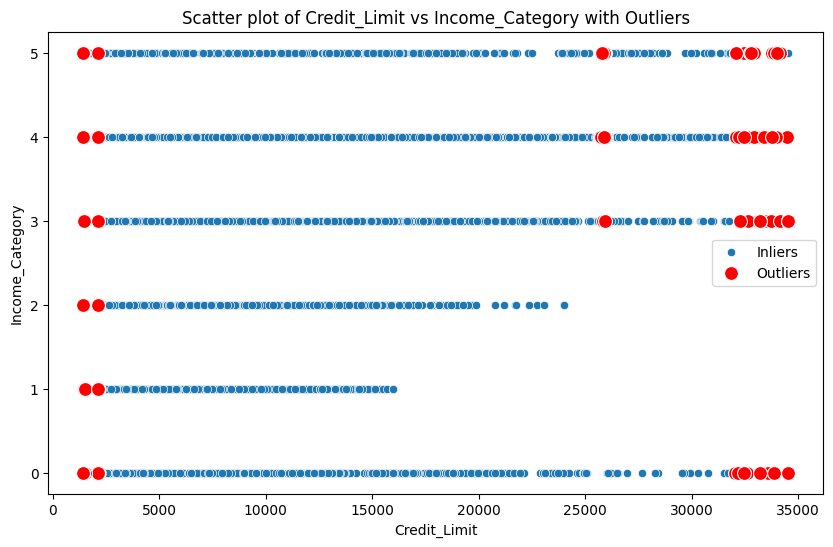

In [54]:
outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Credit_Limit', 'Income_Category', 100, 0.05)

In [55]:
train_df.describe().T

count         mean          std       min  \
Customer_Age              7416.0    46.221484     7.929223    26.000   
Gender                    7416.0     0.467907     0.499003     0.000   
Dependent_count           7416.0     2.356392     1.294683     0.000   
Education_Level           7416.0     2.588323     1.692240     0.000   
Marital_Status            7416.0     2.202265     0.790589     0.000   
Income_Category           7416.0     2.098031     1.474793     0.000   
Card_Category             7416.0     0.055016     0.228027     0.000   
Months_on_book            7416.0    35.884314     7.898289    13.000   
Total_Relationship_Count  7416.0     3.820985     1.554445     1.000   
Months_Inactive_12_mon    7416.0     2.329693     0.997022     0.000   
Contacts_Count_12_mon     7416.0     2.437163     1.088821     0.000   
Credit_Limit              7416.0  8630.956108  9069.869903  1438.300   
Total_Revolving_Bal       7416.0  1142.093042   790.922062     0.000   
Total_Amt_Chng_Q4_Q1      7416.0     0.755931     0.196342     0.198   
Total_Trans_Amt           7416.0  4441.771575  3379.762684   563.000   
Total_Trans_Ct            7416.0    65.758225    23.219285    10.000   
Total_Ct_Chng_Q4_Q1       7416.0     0.706993     0.202988     0.097   
Avg_Utilization_Ratio     7416.0     0.271791     0.273583     0.000   

                               25%       50%          75%        max  
Customer_Age                41.000    46.000     52.00000     70.000  
Gender                       0.000     0.000      1.00000      1.000  
Dependent_count              1.000     2.000      3.00000      5.000  
Education_Level              1.000     3.000      4.00000      6.000  
Marital_Status               2.000     2.000      3.00000      3.000  
Income_Category              1.000     2.000      3.00000      5.000  
Card_Category                0.000     0.000      0.00000      1.000  
Months_on_book              32.000    36.000     40.00000     56.000  
Total_Relationship_Count     3.000     4.000      5.00000      6.000  
Months_Inactive_12_mon       2.000     2.000      3.00000      6.000  
Contacts_Count_12_mon        2.000     2.000      3.00000      6.000  
Credit_Limit              2503.000  4540.500  11239.00000  34516.000  
Total_Revolving_Bal          0.000  1268.000   1740.25000   2517.000  
Total_Amt_Chng_Q4_Q1         0.632     0.736      0.85600      1.831  
Total_Trans_Amt           2213.000  3950.000   4740.25000  17064.000  
Total_Trans_Ct              46.000    68.000     81.00000    139.000  
Total_Ct_Chng_Q4_Q1          0.586     0.702      0.81800      2.167  
Avg_Utilization_Ratio        0.000     0.172      0.50025      0.995


# Feature Selection


In [56]:
def vif_importance(data):

    vif_data = pd.DataFrame()
    vif_data['Feature'] = train_df.columns
    vif_data['VIF'] = [variance_inflation_factor(train_df.values, i) for i in range(train_df.shape[1])]
    
    
    X = train_df.drop('Credit_Limit', axis='columns')
    y = train_df['Credit_Limit']
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    })
    
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    combined_data = pd.merge(feature_importances, vif_data, on='Feature', how='inner')
    
    info = combined_data.sort_values(by='Importance', ascending=False)
    return info

In [57]:
# info = vif_importance(train_df)

In [58]:
# print(info) 

In [59]:
'''
                     Feature  Importance        VIF
0      Avg_Utilization_Ratio    0.423976   5.733280
1            Income_Category    0.217079   8.463035
2        Total_Revolving_Bal    0.158359   6.818633
3              Card_Category    0.085800   1.368058
4            Total_Trans_Amt    0.018901   8.875106
5        Total_Ct_Chng_Q4_Q1    0.015670  15.430608
6       Total_Amt_Chng_Q4_Q1    0.014443  16.485472
7             Total_Trans_Ct    0.012514  25.027169
8             Months_on_book    0.010501  57.502447
9               Customer_Age    0.009608  78.541473
10  Total_Relationship_Count    0.006471   7.730422
11           Education_Level    0.006031   3.255891
12           Dependent_count    0.005262   4.203624
13    Months_Inactive_12_mon    0.004799   6.235826
14     Contacts_Count_12_mon    0.004763   5.713434
15            Marital_Status    0.004356   8.347183
16                    Gender    0.001466   4.916800

'''

'\n                     Feature  Importance        VIF\n0      Avg_Utilization_Ratio    0.423976   5.733280\n1            Income_Category    0.217079   8.463035\n2        Total_Revolving_Bal    0.158359   6.818633\n3              Card_Category    0.085800   1.368058\n4            Total_Trans_Amt    0.018901   8.875106\n5        Total_Ct_Chng_Q4_Q1    0.015670  15.430608\n6       Total_Amt_Chng_Q4_Q1    0.014443  16.485472\n7             Total_Trans_Ct    0.012514  25.027169\n8             Months_on_book    0.010501  57.502447\n9               Customer_Age    0.009608  78.541473\n10  Total_Relationship_Count    0.006471   7.730422\n11           Education_Level    0.006031   3.255891\n12           Dependent_count    0.005262   4.203624\n13    Months_Inactive_12_mon    0.004799   6.235826\n14     Contacts_Count_12_mon    0.004763   5.713434\n15            Marital_Status    0.004356   8.347183\n16                    Gender    0.001466   4.916800\n\n'

In [60]:
columns_to_remove = ['Gender', 'Marital_Status', 'Months_Inactive_12_mon', 'Customer_Age',
                     'Total_Trans_Ct', 'Total_Amt_Chng_Q4_Q1']

In [61]:
train_df = train_df.drop(columns_to_remove, axis='columns')
test_df = test_df.drop(columns_to_remove, axis='columns')

In [62]:
print(train_df.shape)

(7416, 12)


In [63]:
# PCA

# pca = PCA(n_components=15)  # Set the number of principal components
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)


# Scaling


In [64]:
x_train = train_df.drop('Credit_Limit', axis='columns')
x_test = test_df.drop('Credit_Limit', axis='columns')

y_train = train_df['Credit_Limit']
y_test = test_df['Credit_Limit']

In [65]:
print(f"x_train : {x_train.shape}")
print(f"y_train : {y_train.shape}")

x_train : (7416, 11)
y_train : (7416,)


In [66]:
x_train, x_test = Preprocessing.scale(x_train, x_test)

In [67]:
print(x_train)

[[0.6        0.66666667 0.2        ... 0.22271377 0.33961353 0.45628141]
 [0.4        0.33333333 0.2        ... 0.19507909 0.26280193 0.73266332]
 [0.4        0.66666667 0.8        ... 0.12647718 0.37101449 0.12562814]
 ...
 [0.8        0.66666667 0.2        ... 0.24937883 0.43623188 0.67236181]
 [0.6        0.         0.4        ... 0.05569359 0.10386473 0.48140704]
 [0.8        0.33333333 0.6        ... 0.23689473 0.24975845 0.        ]]



# Tain Model and Evaluate


In [68]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
rf.fit(x_train, y_train)
        
oob_score = rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
        
y_pred = rf.predict(x_test)
        
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
        
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2): {r2}')

Out-of-Bag Score: 0.8759943422028343
Mean Squared Error (MSE): 11498611.525683442
R-squared (R2): 0.8613838368220683


In [69]:
'''

Out-of-Bag Score: 0.8871661646762087
Mean Squared Error (MSE): 9697483.072144547
R-squared (R2): 0.8860854003358002

'''

'\n\nOut-of-Bag Score: 0.8871661646762087\nMean Squared Error (MSE): 9697483.072144547\nR-squared (R2): 0.8860854003358002\n\n'

In [70]:
X = train_df.drop('Credit_Limit', axis='columns')
y = train_df['Credit_Limit']

kmeans = KMeans(n_clusters=4)  # Set the number of clusters as desired
clusters = kmeans.fit_predict(X)

regressors = {}

for cluster_label in range(kmeans.n_clusters):
    # Filter data points belonging to the current cluster
    X_cluster = X[clusters == cluster_label]
    y_cluster = y[clusters == cluster_label]
    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
    
    regressor = RandomForestRegressor()
    regressor.fit(X_train_c, y_train_c)
    
    regressors[cluster_label] = regressor
    
    score = regressor.score(X_test_c, y_test_c)
    print(f"Cluster {cluster_label}: R^2 Score = {score}")

new_clusters = kmeans.predict(test_df.drop('Credit_Limit', axis='columns'))

for i, cluster_label in enumerate(new_clusters):
    X_new_cluster = test_df.drop('Credit_Limit', axis='columns')[i:i+1]  
    predicted_value = regressors[cluster_label].predict(X_new_cluster)
    # print(f"Predicted value for data point {i}: {predicted_value}")


D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: R^2 Score = 0.8788099002994085
Cluster 1: R^2 Score = 0.8169827838826318
Cluster 2: R^2 Score = 0.8628272289155492
Cluster 3: R^2 Score = 0.8196148348081134


In [71]:
total_samples = len(X)  
total_r2 = 0  

for cluster_label in range(kmeans.n_clusters):
    X_cluster = X[clusters == cluster_label]
    y_cluster = y[clusters == cluster_label]
    
    cluster_weight = len(X_cluster) / total_samples
    regressor = regressors[cluster_label]
    r2_score = regressor.score(X_cluster, y_cluster)
    total_r2 += cluster_weight * r2_score

print(f"Total R^2 score: {total_r2}")


Total R^2 score: 0.9506555527095379


In [72]:
total_samples = len(X)  
total_mse = 0  

for cluster_label in range(kmeans.n_clusters):
    X_cluster = X[clusters == cluster_label]
    y_cluster = y[clusters == cluster_label]
    
    cluster_weight = len(X_cluster) / total_samples
    regressor = regressors[cluster_label]
    y_pred = regressor.predict(X_cluster)
    mse = mean_squared_error(y_cluster, y_pred)
    total_mse += cluster_weight * mse

print(f"Total MSE: {total_mse}")


Total MSE: 3711590.323307436


In [73]:
'''
Total R^2 score: 0.959061602532588
Total MSE: 3264882.097322209
'''

'\nTotal R^2 score: 0.959061602532588\nTotal MSE: 3264882.097322209\n'